In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap, jacfwd, jvp, vjp
from jax import random

In [13]:
import jax.numpy as jnp
import jax
from emlp_jax.groups import SO
from emlp_jax.model_trainer import RegressorPlus
from emlp_jax.hamiltonian_dynamics import IntegratedDynamicsTrainer,DoubleSpringPendulum,HamiltonianFlow
import numpy as np
from torch.utils.data import DataLoader
from oil.utils.utils import cosLr, islice, export,FixedNumpySeed,FixedPytorchSeed,Named
from slax.utils import LoaderTo
from oil.datasetup.datasets import split_dataset
import logging
import emlp_jax
import objax
from emlp_jax.mlp import MLPBlock,Sequential,swish
import objax.nn as nn
import objax.functional as F
from objax.module import Module


class MLP2(Module,metaclass=Named):
    def __init__(self,rep_in,rep_out,group,ch=384,num_layers=3):
        super().__init__()
        self.rep_in =rep_in(group)
        self.rep_out = rep_out(group)
        self.G = group
        chs = [self.rep_in.size()] + num_layers*[ch]
        cout = self.rep_out.size()
        logging.info("Initing MLP")
        self.net = Sequential(
            *[Sequential(nn.Linear(cin,cout),swish) for cin,cout in zip(chs,chs[1:])],
            nn.Linear(chs[-1],cout)
        )
    def __call__(self,x):#,training=True):
        y = self.net(x).sum()
        return y

def makeTrainer(*,dataset=DoubleSpringPendulum,network=MLP2,num_epochs=1000,ndata=5000,seed=2021,aug=False,
                bs=500,lr=3e-3,device='cuda',split={'train':500,'val':.1,'test':.1},
                net_config={'num_layers':3,'ch':384,'group':None},log_level='info',
                trainer_config={'log_dir':None,'log_args':{'minPeriod':.02,'timeFrac':.75},},#'early_stop_metric':'val_MSE'},
                save=False,):
    levels = {'critical': logging.CRITICAL,'error': logging.ERROR,
                        'warn': logging.WARNING,'warning': logging.WARNING,
                        'info': logging.INFO,'debug': logging.DEBUG}
    logging.getLogger().setLevel(levels[log_level])
    # Prep the datasets splits, model, and dataloaders
    with FixedNumpySeed(seed),FixedPytorchSeed(seed):
        base_ds = dataset(n_systems=ndata,chunk_len=5)
        datasets = split_dataset(base_ds,splits=split)
    if net_config['group'] is None: net_config['group']=base_ds.symmetry
    model = network(base_ds.rep_in,base_ds.rep_out,**net_config)
    #if aug: model = datasets['train'].default_aug(model)
    #model = Standardize(model,datasets['train'].stats)
    dataloaders = {k:LoaderTo(DataLoader(v,batch_size=min(bs,len(v)),shuffle=(k=='train'),
                num_workers=0,pin_memory=False)) for k,v in datasets.items()}
    dataloaders['Train'] = dataloaders['train']
    #equivariance_test(model,dataloaders['train'],net_config['group'])
    opt_constr = objax.optimizer.Adam
    lr_sched = lambda e: lr#*cosLr(num_epochs)(e)#*min(1,e/(num_epochs/10))
    return IntegratedDynamicsTrainer(model,dataloaders,opt_constr,lr_sched,**trainer_config)



In [3]:
trainer = makeTrainer()

INFO:root:Initing MLP


In [5]:
trainer.train(1000)

train:   0%|          | 0/1000 [00:00<?, ?it/s]

      val_MSE  test_MSE  Train_MSE
100  0.018544  0.018224   0.018284
      val_MSE  test_MSE  Train_MSE
122  0.017125   0.01678   0.016869
      val_MSE  test_MSE  Train_MSE
144  0.012995  0.012628   0.012783
     val_MSE  test_MSE  Train_MSE
166  0.00807  0.007688    0.00777
      val_MSE  test_MSE  Train_MSE
189  0.003046   0.00289    0.00286
      val_MSE  test_MSE  Train_MSE
211  0.001207  0.001221   0.001165
      val_MSE  test_MSE  Train_MSE
233  0.001054  0.001071   0.001015
      val_MSE  test_MSE  Train_MSE
255  0.001004  0.001021   0.000967
      val_MSE  test_MSE  Train_MSE
277  0.000981  0.000995   0.000944
      val_MSE  test_MSE  Train_MSE
299  0.001004   0.00102   0.000972
     val_MSE  test_MSE  Train_MSE
321  0.00095  0.000966   0.000911
      val_MSE  test_MSE  Train_MSE
343  0.000927  0.000945   0.000891
      val_MSE  test_MSE  Train_MSE
364  0.000912   0.00093   0.000875
      val_MSE  test_MSE  Train_MSE
386  0.000895  0.000914   0.000858
      val_MSE  test_MSE 

In [8]:
ds =trainer.dataloaders['train'].dataset

In [11]:
minibatch = next(iter(trainer.dataloaders['test']))

In [19]:
(z0, ts), true_zs = minibatch
pred_zs = HamiltonianFlow(trainer.model,z0,ds.T_long)
gt_zs  = HamiltonianFlow(ds.H,z0,ds.T_long)

In [20]:
def rel_err(a,b):
    return jnp.sqrt(((a-b)**2).mean())/(jnp.sqrt((a**2).mean())+jnp.sqrt((b**2).mean()))#

In [23]:
gt_zs.shape

(500, 200, 12)

In [25]:
errs = vmap(vmap(rel_err))(pred_zs,gt_zs)

In [27]:
import matplotlib.pyplot as plt

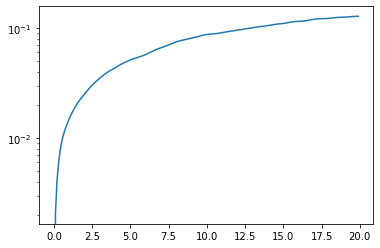

In [44]:
geo_mean = jnp.exp(jnp.log(errs).mean(0))
geo_std = jnp.exp(jnp.log(errs).std(0))
plt.plot(ds.T_long,geo_mean)
#plt.errorbar(ds.T_long,geo_mean,yerr=np.stack((geo_mean/geo_std,geo_std*geo_mean)))
plt.yscale('log')

In [40]:
geo_std/geo_mean

DeviceArray([         nan, 1209.7068   ,  612.22614  ,  419.54852  ,
              326.77258  ,  272.9874   ,  237.8548   ,  211.42752  ,
              190.9411   ,  173.5772   ,  158.67453  ,  146.34254  ,
              135.74385  ,  126.4704   ,  118.52422  ,  111.973755 ,
              106.459305 ,  101.65668  ,   97.323135 ,   93.25376  ,
               89.32699  ,   85.41922  ,   81.484825 ,   77.6486   ,
               74.11707  ,   70.985    ,   68.204414 ,   65.679245 ,
               63.30442  ,   61.06311  ,   59.074207 ,   57.40878  ,
               55.998436 ,   54.66999  ,   53.300854 ,   51.921078 ,
               50.576397 ,   49.2736   ,   48.011707 ,   46.75672  ,
               45.47267  ,   44.178802 ,   42.96212  ,   41.90317  ,
               41.022644 ,   40.29754  ,   39.66051  ,   39.032776 ,
               38.35608  ,   37.613445 ,   36.848564 ,   36.11176  ,
               35.422867 ,   34.760574 ,   34.076996 ,   33.35868  ,
               32.632927 ,   31.92

In [32]:
geo_std

DeviceArray([      nan, 2.4751952, 2.4681492, 2.4710836, 2.4765673,
             2.4792693, 2.4774084, 2.4596488, 2.4357865, 2.404979 ,
             2.3742857, 2.3503032, 2.3278456, 2.3049846, 2.285028 ,
             2.2724805, 2.265453 , 2.2614748, 2.258084 , 2.252857 ,
             2.2446358, 2.231743 , 2.2130265, 2.1901066, 2.166699 ,
             2.1454427, 2.1269524, 2.1107821, 2.095541 , 2.0810053,
             2.0703626, 2.0659661, 2.0665288, 2.0676656, 2.065122 ,
             2.0579233, 2.0462875, 2.0307932, 2.01299  , 1.99417  ,
             1.9752046, 1.9571767, 1.9419026, 1.9308496, 1.9244026,
             1.9221008, 1.9216298, 1.9198859, 1.9145396, 1.9046265,
             1.8911971, 1.8759816, 1.860191 , 1.843651 , 1.8250867,
             1.8045027, 1.7834464, 1.7632896, 1.743798 , 1.7236017,
             1.7026286, 1.6815917, 1.6611744, 1.64192  , 1.6239055,
             1.6073742, 1.5929486, 1.5808024, 1.5700644, 1.5593476,
             1.5483574, 1.5381492, 1.5296772, 1.

In [2]:
from chex import ArrayDevice, assert_shape, assert_rank

In [3]:
#%pip install ffmpeg

In [6]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import numpy as np

class Animation(object):
    def __init__(self, qt,lims=None):
        """ [qt (T,n,d)"""
        self.qt = qt
        T,n,d = qt.shape
        assert d in (2,3), "too many dimensions for animation"
        self.fig = plt.figure()
        self.ax = self.fig.add_axes([0, 0, 1, 1],projection='3d') if d==3 else self.fig.add_axes([0, 0, 1, 1])
        
        #self.ax.axis('equal')
        xyzmin = self.qt.min(0).min(0)#.min(dim=0)[0].min(dim=0)[0]
        xyzmax = self.qt.max(0).max(0)#.max(dim=0)[0].max(dim=0)[0]
        delta = xyzmax-xyzmin
        lower = xyzmin-.1*delta; upper = xyzmax+.1*delta
        if lims is None:
            lims = (min(lower),max(upper)),(min(lower),max(upper)),(min(lower),max(upper))
        self.ax.set_xlim(lims[0])
        self.ax.set_ylim(lims[1])
        if d==3: self.ax.set_zlim(lims[2])
        if d!=3: self.ax.set_aspect("equal")
        #elf.ax.auto_scale_xyz()
        empty = d*[[]]
        self.colors = np.random.choice([f"C{i}" for i in range(10)],size=n,replace=False)
        self.objects = {
            'pts':sum([self.ax.plot(*empty, "o", ms=6,color=self.colors[i]) for i in range(n)], []),
            'traj_lines':sum([self.ax.plot(*empty, "-",color=self.colors[i]) for i in range(n)], []),
        }
        
    def init(self):
        empty = 2*[[]]
        for obj in self.objects.values():
            for elem in obj:
                elem.set_data(*empty)
                #if self.qt.shape[-1]==3: elem.set_3d_properties([])
        return sum(self.objects.values(),[])

    def update(self, i=0):
        T,n,d = self.qt.shape
        trail_len = 50
        for j in range(n):
            # trails
            xyz = self.qt[max(i - trail_len,0): i + 1,j,:]
            #chunks = xyz.shape[0]//10
            #xyz_chunks = torch.chunk(xyz,chunks)
            #for i,xyz in enumerate(xyz_chunks):
            self.objects['traj_lines'][j].set_data(*xyz[...,:2].T)
            if d==3: self.objects['traj_lines'][j].set_3d_properties(xyz[...,2].T)
            self.objects['pts'][j].set_data(*xyz[-1:,...,:2].T)
            if d==3: self.objects['pts'][j].set_3d_properties(xyz[-1:,...,2].T)
        #self.fig.canvas.draw()
        return sum(self.objects.values(),[])

    def animate(self):
        return animation.FuncAnimation(self.fig,self.update,frames=self.qt.shape[0],
                    interval=33,init_func=self.init,blit=True).to_html5_video()

class PendulumAnimation(Animation):
    def __init__(self, qt):
        super().__init__(qt)
        empty = self.qt.shape[-1] * [[]]
        self.objects["pts"] = sum([self.ax.plot(*empty, "o", ms=10,c=self.colors[i]) for i in range(self.qt.shape[1])], [])

    def update(self, i=0):
        return super().update(i)

def helix(Ns=1000,radius=.05,turns=25):
    t = np.linspace(0,1,Ns)
    xyz = np.zeros((Ns,3))
    xyz[:,0] = np.cos(2*np.pi*Ns*t*turns)*radius
    xyz[:,1] = np.sin(2*np.pi*Ns*t*turns)*radius
    xyz[:,2] = t
    xyz[:,:2][(t>.9)|(t<.1)]=0
    return xyz

def align2ref(refs,vecs):
    """ inputs [refs (n,3), vecs (N,3)]
        outputs [aligned (n,N,3)]
    assumes vecs are pointing along z axis"""
    n,_ = refs.shape
    N,_ = vecs.shape
    norm = np.sqrt((refs**2).sum(-1))
    v = refs/norm[:,None]
    A = np.zeros((n,3,3))
    A[:,:,2] += v
    A[:,2,:] -= v
    M = (np.eye(3)+A+(A@A)/(1+v[:,2,None,None]))*norm[:,None,None]
    return (M[:,None]@vecs[None,...,None]).squeeze(-1)

    
class CoupledPendulumAnimation(PendulumAnimation):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        empty = self.qt.shape[-1]*[[]]
        self.objects["springs"] = self.ax.plot(*empty,c='k',lw=.6)#
        #self.objects["springs"] = sum([self.ax.plot(*empty,c='k',lw=2) for _ in range(self.n-1)],[])
        self.helix = helix(200,turns=10)
        
    def update(self,i=0):
        qt_padded = np.concatenate([0*self.qt[i,:1],self.qt[i,:]],axis=0)
        diffs = qt_padded[1:]-qt_padded[:-1]
        x,y,z = (align2ref(diffs,self.helix)+qt_padded[:-1][:,None]).reshape(-1,3).T
        self.objects['springs'][0].set_data(x,y)
        self.objects['springs'][0].set_3d_properties(z)
        return super().update(i)

In [7]:
# key = random.PRNGKey(0)
# d = 1000
# x = random.normal(key, (d,))
# p = random.normal(key, (d,))
# z = pack(x, p)

# X = jnp.stack([x, x, x])

In [8]:
import numpy as np
import jax.numpy as jnp
from jax.experimental.ode import odeint

def unpack(z):
    D = jnp.shape(z)[-1]
    assert D % 2 == 0
    d = D//2
    q, p_or_v = z[..., :d], z[..., d:]
    return q, p_or_v

def pack(q, p_or_v):
    return jnp.concatenate([q, p_or_v], axis=-1)

def symplectic_form(z):
    q, p = unpack(z)
    return pack(p, -q)

def hamiltonian_dynamics(hamiltonian, z,t):
    grad_h = grad(hamiltonian)
    return symplectic_form(grad_h(z))

def HamiltonianFlow(H,z0,T):
    dynamics = lambda z,t: hamiltonian_dynamics(H,z,t)
    return odeint(dynamics, z0, T, rtol=1e-6, atol=1e-6).transpose((1,0,2))

In [9]:
from torch.utils.data import Dataset
class HamiltonianDataset(Dataset):

    def __init__(self,n_systems=100,chunk_len=5,dt=0.1,integration_time=20):
        super().__init__()
        zs = self.generate_trajectory_data(n_systems, dt, integration_time)
        self.Zs = self.chunk_training_data(zs, chunk_len)
        self.T = jnp.arange(0, chunk_len*dt, dt)
        self.T_long = jnp.arange(0,integration_time,dt)
    def __len__(self):
        return self.Zs.shape[0]

    def __getitem__(self, i):
        return (self.Zs[i, 0], self.T), self.Zs[i]

    def integrate(self,z0s,ts):
        return HamiltonianFlow(self.H,z0s, ts)
    
    def generate_trajectory_data(self, n_systems, dt, integration_time, bs=100):
        """ Returns ts: (n_systems, traj_len) zs: (n_systems, traj_len, z_dim) """
        n_gen = 0; bs = min(bs, n_systems)
        t_batches, z_batches = [], []
        while n_gen < n_systems:
            z0s = self.sample_initial_conditions(bs)
            ts = jnp.arange(0, integration_time, dt)
            new_zs = HamiltonianFlow(self.H,z0s, ts)
            z_batches.append(new_zs)
            n_gen += bs
        zs = jnp.concatenate(z_batches, axis=0)[:n_systems]
        return zs

    def chunk_training_data(self, zs, chunk_len):
        batch_size, traj_len, *z_dim = zs.shape
        n_chunks = traj_len // chunk_len
        chunk_idx = np.random.randint(0, n_chunks, (batch_size,))
        chunked_zs = np.stack(np.split(zs,n_chunks, axis=1))
        chosen_zs = chunked_zs[chunk_idx, np.arange(batch_size)]
        return chosen_zs

    def H(self,z):
        raise NotImplementedError
    def sample_initial_conditions(self,bs):
        raise NotImplementedError
    def animate(self, zt=None):
        if zt is None:
            zt = np.asarray(self.integrate(self.sample_initial_conditions(10),self.T_long))
        # bs, T, 2nd
        if len(zt.shape) == 3:
            j = np.random.randint(zt.shape[0])
            zt = zt[j]
        xt,pt = unpack(zt)
        xt = xt.reshape((xt.shape[0],-1,3))
        anim = self.animator(xt)
        return anim.animate()

In [10]:
class SHO(HamiltonianDataset):
    def H(self,z):
        ke = (z[...,1]**2).sum()/2
        pe = (z[...,0]**2).sum()/2
        return ke+pe
    def sample_initial_conditions(self,bs):
        return np.random.randn(bs,2)
    
class DoubleSpringPendulum(HamiltonianDataset):
    def H(self,z):
        g=1
        m1,m2,k1,k2,l1,l2 = 1,1,1,1,1,1
        x,p = unpack(z)
        p1,p2 = unpack(p)
        x1,x2 = unpack(x)
        ke = .5*(p1**2).sum(-1)/m1 + .5*(p2**2).sum(-1)/m2
        pe = .5*k1*(jnp.sqrt((x1**2).sum(-1))-l1)**2 
        pe += k2*(jnp.sqrt(((x1-x2)**2).sum(-1))-l2)**2
        pe += m1*g*x1[...,2]+m2*g*x2[...,2]
        return (ke + pe).sum()
    def sample_initial_conditions(self,bs):
        x1 = np.array([0,0,-1.5]) +.2*np.random.randn(bs,3)
        x2= np.array([0,0,-3.]) +.2*np.random.randn(bs,3)
        p = .4*np.random.randn(bs,6)
        z0 = np.concatenate([x1,x2,p],axis=-1)
        return z0
    @property
    def animator(self):
        return CoupledPendulumAnimation

In [13]:
ds = DoubleSpringPendulum()

In [ ]:
from ipywidgets import interact
Pc = ChainPendulum(3)
@interact(i=(0,ztc.shape[1]),k=(0,ztc.shape[0]))
def make_fig(i=163,k=31):
    anim = Pc.animator(ztc[k,:,0],Pc)
    anim.init()
    anim.update(i=i)
    plt.axis('off')
    plt.savefig(f"system{Pc}.pdf", bbox_inches="tight")

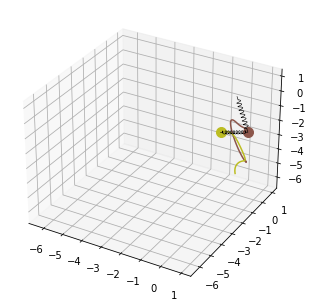

In [14]:
from IPython.display import HTML
HTML(ds.animate())

In [98]:
%debug

> <ipython-input-91-cb6c627cd633>(82)align2ref()
     80         outputs [aligned (n,N,3)]
     81     assumes vecs are pointing along z axis"""
---> 82     n,_ = refs.shape
     83     N,_ = vecs.shape
     84     norm = np.sqrt((refs**2).sum(-1))

ipdb> refs.shape
(2,)
ipdb> q


In [ ]:
import torch.nn as nn

class Swish(nn.Module):
  def forward(self,x):
    return x*torch.sigmoid(x)

def FCswish(chin, chout):
    return nn.Sequential(nn.Linear(chin, chout), Swish())

def FCtanh(chin, chout):
    return nn.Sequential(nn.Linear(chin, chout), nn.Tanh())

class MLP(nn.Module):
    def __init__(self,z_dim, k=256, num_layers=4, num_outputs=1):
        super().__init__()
        self.net = nn.Sequential(
            FCswish(z_dim,k),
            *[FCswish(k,k) for _ in range(num_layers-1)],
            nn.Linear(k, num_outputs)
        )
    def forward(self,z):
        return self.net(z).squeeze(-1)

In [ ]:
from oil.model_trainers import Trainer
class IntegratedDynamicsTrainer(Trainer):

    def loss(self, minibatch):
        """ Standard cross-entropy loss """
        (z0, ts), true_zs = minibatch
        pred_zs = HamiltonianFlow(self.model,z0,ts[0],higher=True)
        return (pred_zs - true_zs).pow(2).mean()

    def metrics(self, loader):
        mse = lambda mb: self.loss(mb).cpu().data.numpy()
        return {"MSE": self.evalAverageMetrics(loader, mse)}

In [ ]:
from functools import partial
from torch.utils.data import DataLoader
from torch.optim import Adam
import numpy as np

num_epochs = 500

datasets = split_dataset(dataset,{'train':2/3,'test':1/3})
dataloaders = {k: DataLoader(v,batch_size=1000) for k,v in datasets.items()}
optim = partial(Adam,lr=3e-3)
model = MLP(z_dim)
lr_sched = lambda e: np.cos((e/num_epochs)*np.pi/2)
trainer = IntegratedDynamicsTrainer(model,dataloaders,optim,lr_sched,log_args={'minPeriod':0.1})